# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [1]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 3

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [2]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [3]:
##first we split the data into the test and trining data and we then also convert them into pytorch tensors to be used in the matrix operations
from sklearn.model_selection import train_test_split
Xtrain_np, Xtest_np , Ytrain_np, Ytest_np = train_test_split(X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER)
Xtrain = torch.tensor(Xtrain_np, dtype=torch.float32)
Xtest = torch.tensor(Xtest_np, dtype=torch.float32)
Ytrain = torch.tensor(Ytrain_np, dtype=torch.float32)
Ytest = torch.tensor(Ytest_np, dtype=torch.float32)

W1 = torch.randn(2, 16)*0.25     ## we multiply by a small number in the wieghts so that there is no probleme of vanisghing geadient point..i looke it up on the internet and learnt that if a number comes very big then the sigmoid curve wil be very flat near 1 and 0 thus the gradient will be almost zero and thus no learning wil take place or it will be very slow so to prevent itwe multiply by a small number and generalyy we multiply by 1/sqrt of number of neurons
W1.requires_grad_()
b1 = torch.randn(16, requires_grad=True)
W2 = torch.randn(16, 16)*0.25
W2.requires_grad_()
b2 = torch.randn(16, requires_grad=True)
W3 = torch.randn(16, 16)*0.25
W3.requires_grad_()
b3 = torch.randn(16, requires_grad=True)
W4 = torch.randn(16, 1)*0.25
W4.requires_grad_()
b4 = torch.randn(1, requires_grad=True)

parametres = [W1, b1, W2, b2, W3, b3, W4, b4]

epochs = 10000
lr = 0.01    ## checked many values of lr and epochs ..for this learning rate and less epochs like 1000,accuracy was low..so now i have increasd the number of epochs now
eps = 1e-6    ## this is used to prevent log(0) situations
loss_train = []
loss_test = []
acc_train = []
acc_test = []

for ite in range(epochs):
  y1 = torch.matmul(Xtrain, W1) + b1
  a1 = torch.relu(y1)
  y2 = torch.matmul(a1, W2) + b2
  a2 = torch.relu(y2)
  y3 = torch.matmul(a2, W3) + b3
  a3 = torch.relu(y3)
  y4 = torch.matmul(a3, W4) + b4

  train_y_predicted = 1/(1+torch.exp(-y4))
  train_y_predicted = torch.clamp(train_y_predicted,eps,1-eps)
  ##bce loss
  bce_loss = -torch.mean(Ytrain*torch.log(train_y_predicted) + (1-Ytrain)*torch.log(1-train_y_predicted))
  ##backpropogation
  bce_loss.backward()

  train_acc_check = (train_y_predicted >= 0.5).float()
  train_acc_values = torch.mean((train_acc_check == Ytrain).float())
  ##training loss and accuracy values to be stored
  loss_train.append(bce_loss.item())
  acc_train.append(train_acc_values.item())
  ##manual gradient descent
  with torch.no_grad():
    for p in parametres:
      p -= lr*p.grad
      p.grad.zero_()
  ##validation and checking on test data
  with torch.no_grad():
    y1_test = torch.matmul(Xtest, W1) + b1
    a1_test = torch.relu(y1_test)
    y2_test = torch.matmul(a1_test, W2) + b2
    a2_test = torch.relu(y2_test)
    y3_test = torch.matmul(a2_test, W3) + b3
    a3_test = torch.relu(y3_test)
    y4_test = torch.matmul(a3_test, W4) + b4
    ##predicted values of y from test darta
    test_y_predicted = 1/(1+torch.exp(-y4_test))
    test_y_predicted = torch.clamp(test_y_predicted,eps,1-eps)
    test_loss = -torch.mean(Ytest*torch.log(test_y_predicted) + (1-Ytest)*torch.log(1-test_y_predicted))

    test_acc_check = (test_y_predicted >= 0.5).float()
    test_acc_values = torch.mean((test_acc_check == Ytest).float())
  ##test losses and accuracy stored
    loss_test.append(test_loss.item())
    acc_test.append(test_acc_values.item())


  if ite%500==0:
    print(f"Epoch {ite} | Loss : {bce_loss.item():.4f} | Val Acc : {test_acc_values.item():.2f}")
##final accuracy
final_test_acc = acc_test[-1]
final_test_acc *= 100
print(f"Final Accuracy : {final_test_acc:.2f}%")


/tmp/ipython-input-3907740335.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain = torch.tensor(Xtrain_np, dtype=torch.float32)
/tmp/ipython-input-3907740335.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtest = torch.tensor(Xtest_np, dtype=torch.float32)
/tmp/ipython-input-3907740335.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ytrain = torch.tensor(Ytrain_np, dtype=torch.float32)
/tmp/ipython-input-3907740335.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() o

Epoch 0 | Loss : 1.1203 | Val Acc : 0.41
Epoch 500 | Loss : 0.6309 | Val Acc : 0.59
Epoch 1000 | Loss : 0.6008 | Val Acc : 0.53
Epoch 1500 | Loss : 0.5647 | Val Acc : 0.56
Epoch 2000 | Loss : 0.5350 | Val Acc : 0.64
Epoch 2500 | Loss : 0.5057 | Val Acc : 0.68
Epoch 3000 | Loss : 0.4656 | Val Acc : 0.73
Epoch 3500 | Loss : 0.4168 | Val Acc : 0.82
Epoch 4000 | Loss : 0.3696 | Val Acc : 0.87
Epoch 4500 | Loss : 0.3319 | Val Acc : 0.89
Epoch 5000 | Loss : 0.3084 | Val Acc : 0.91
Epoch 5500 | Loss : 0.2933 | Val Acc : 0.91
Epoch 6000 | Loss : 0.2843 | Val Acc : 0.92
Epoch 6500 | Loss : 0.2786 | Val Acc : 0.92
Epoch 7000 | Loss : 0.2744 | Val Acc : 0.92
Epoch 7500 | Loss : 0.2709 | Val Acc : 0.92
Epoch 8000 | Loss : 0.2684 | Val Acc : 0.92
Epoch 8500 | Loss : 0.2669 | Val Acc : 0.92
Epoch 9000 | Loss : 0.2655 | Val Acc : 0.92
Epoch 9500 | Loss : 0.2644 | Val Acc : 0.92
Final Accuracy : 92.33%


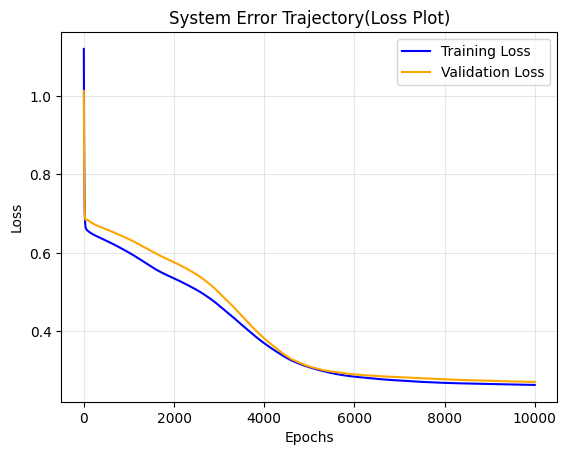

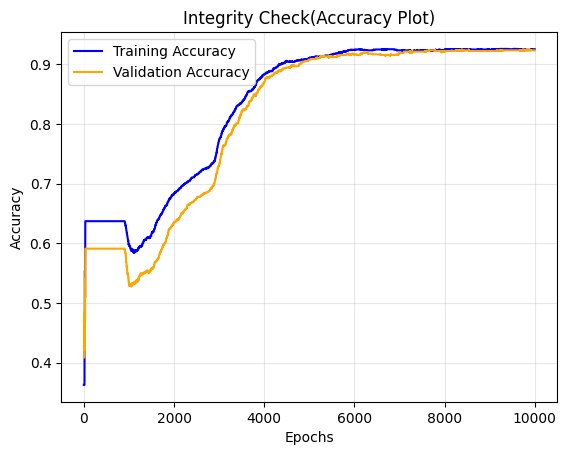

In [4]:
import matplotlib.pyplot as plt
##loss plot
plt.figure()
plt.plot(loss_train, label="Training Loss",color = 'blue')
plt.plot(loss_test, label="Validation Loss",color = 'orange')
plt.title("System Error Trajectory(Loss Plot)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##accuracy plot
plt.plot(acc_train,label = "Training Accuracy",color = 'blue')
plt.plot(acc_test,label = "Validation Accuracy",color = 'orange')
plt.title("Integrity Check(Accuracy Plot)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



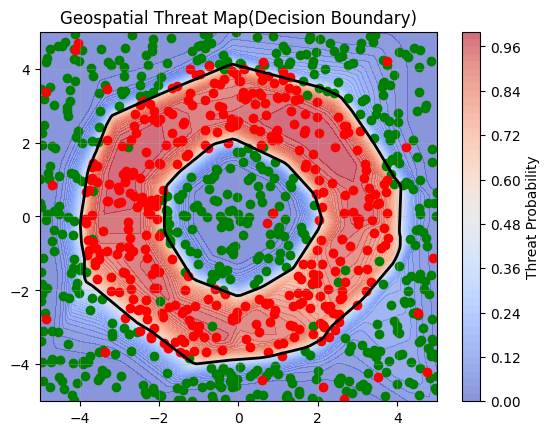

In [5]:
##i have taken help from the internet to help in implement some of the things below
#creating the grid first
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x_range, y_range)

grid_np = np.c_[xx.ravel(),yy.ravel()]
grid_tensor = torch.tensor(grid_np, dtype=torch.float32)
##forward pass
with torch.no_grad():
  g1 = torch.matmul(grid_tensor, W1) + b1
  g1 = torch.relu(g1)
  g2 = torch.matmul(g1, W2) + b2
  g2 = torch.relu(g2)
  g3 = torch.matmul(g2, W3) + b3
  g3 = torch.relu(g3)
  g4 = torch.matmul(g3, W4) + b4
  g_y_predicted = 1/(1+torch.exp(-g4))

  M = g_y_predicted.reshape(xx.shape).numpy() ## reshaping hte flattened array into grid for plotting


plt.contourf(xx,yy,M,levels=50,cmap = 'coolwarm',alpha=0.6)
plt.colorbar(label = 'Threat Probability')
plt.contour(xx,yy,M,levels=[0.5],colors='black',linewidths=2)  ## this draws the black line, the boundary of the two zones which was essentially our desired output

X_v = Xtest.numpy()
Y_v = Ytest.numpy().flatten()

plt.scatter(X_v[Y_v==0,0],X_v[Y_v==0,1],color='green',label='Safe Zone')
plt.scatter(X_v[Y_v==1,0],X_v[Y_v==1,1],color='red',label='Dead Zone') ##the scatter plot of the safe and dead xzones.

plt.title('Geospatial Threat Map(Decision Boundary)')
plt.grid(True, alpha=0.3)
plt.show()
